# Exploratory Analysis
Brian Bahmanyar

***

In this notebook we want to identify patterns in the movement of the stocks which we can exploit. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import *
import seaborn as sns

import statsmodels.api as sm

import sys
sys.path.append('./src/')
from plots import *

In [2]:
%matplotlib inline
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 
                            'axes.facecolor': '0.9', 
                            'grid.color': '.82', 
                            'legend.frameon': True,
                            'axes.labelsize': 'small'})
#sns.set_context("talk")

In [3]:
tech = pd.read_csv('data/tech_bundle.csv', index_col=0)
tech.index = pd.to_datetime(tech.index)

In [4]:
def plot_stocks(index, stocks, labels, positions=None, label_annually=True):
    """
    Plots up to 5 stocks
    
    Args: index (DateTimeIndex)-------date range
          stocks (list)---------------list of stocks to plot
          labels (list)---------------labels to use for plotting
          positions (list of dicts)---optional postions to overplot
          label_annually (boolean)----plots x label monthly if false, annually otherwise
    Returns: (None) Will output plot inline
    """
    colors = ['firebrick','steelblue','orange','mediumorchid', 'mediumseagreen']
    
    fig, ax = plt.subplots(figsize=(20,8));
    
    if label_annually:
        span = YearLocator();
        my_format = DateFormatter('%Y');
    else:
        span = MonthLocator();
        my_format = DateFormatter('%b %Y');    
    
    ax.xaxis.set_major_locator(span);
    ax.xaxis.set_major_formatter(my_format);
    ax.autoscale_view();
    
    plt.title('Adjusted Close Prices', fontsize=20);
    plt.ylabel('Adj. Close', fontsize=15);
    plt.xlabel('Time', fontsize=15);
    
    for stock, label, color in zip(stocks, labels, colors):
        ax.plot_date(index, stock, color=color, linestyle='-', marker=None, label=label);
        plt.xticks(rotation=45)
    
    if positions:
        for position in positions:
            ax.axvline(df.index[position['open']], color='lime', linestyle='-')
            ax.axvline(df.index[position['close']], color='red', linestyle='-')
 
    plt.legend(loc=2, prop={'size':15}, frameon=True);

Clearly stocks (both Apple, and Facebook) tend to generally increase over time. There doesn't seem to be any obvious seasonal patterns in the series', but lets explore that in a bit more detail.

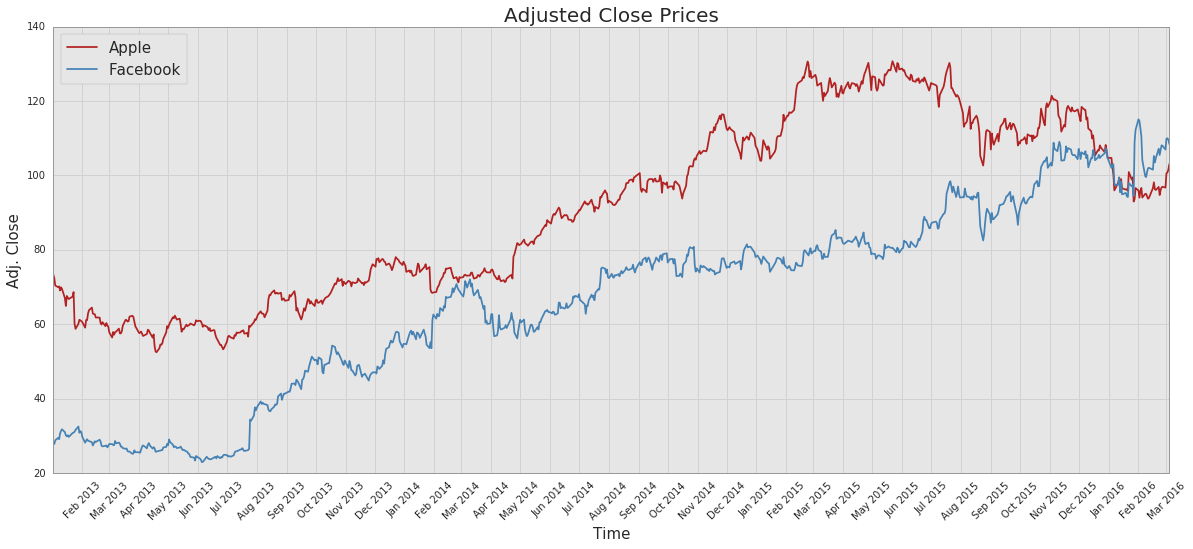

In [5]:
plot_stocks(tech.index, 
            [ tech['AAPL'], tech['FB'] ], 
            [ 'Apple', 'Facebook' ], 
            label_annually=False )

The [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) of a random process describes the correlation between values of the process at different times, as a function of the two times or of the time lag.

The autocorrelation between time s and t is defined as $R(s,t) = \frac{\operatorname{E}[(X_t - \mu_t)(X_s - \mu_s)]}{\sigma_t\sigma_s}\,$

It is important to examine the detrended data to identify any autocorrelation structure in the series. A common approach to detrending data is by taking differences of your series against its lagged self until it becomes [stationary](https://en.wikipedia.org/wiki/Stationary_process). 

In [6]:
def get_lagged_series(series, order=1, log=False):
    """
    Returns a lag of your series on itself
    
    Args: series (ndarray)---time series
          order (int)--------the magnitude of the difference
          log (boolean)------whether or not to log transform before difference
    Returns: (ndarray) the differenced series
    """
    lagged = None
    
    if log:
        lagged = np.log(series).diff(order).dropna();
    else:
        lagged = series.diff(order).dropna();
    
    return lagged

In [7]:
assert(tech.FB.count()-1 == get_lagged_series(tech.FB).count())
assert(tech.FB[1]-tech.FB[0] == get_lagged_series(tech.FB)[0])

In [8]:
def plot_lagged_series(series, order=1, log=False):
    """
    Plots lagged series
    
    Args: series (ndarray)---time series
          order (int)--------the order of the difference
          log (boolean)------whether to log transform before difference
    Returns: (None) plots inline
    """
    plt.figure(figsize=(12,4));
    plt.xlabel('Time Index');
    plt.ylabel('Difference');
    
    if log:
        plt.title('Log Series Lagged by ' + str(order));
        lagged = get_lagged_series(series, order, log)
    else:
        plt.title('Series Lagged by ' + str(order));
        lagged = get_lagged_series(series, order, log)
        
    plt.plot(np.arange(0,lagged.size,1), lagged);

#### Explore Facebook

Facebook's adjusted close tax seems to be approximatley stationary after a first difference.

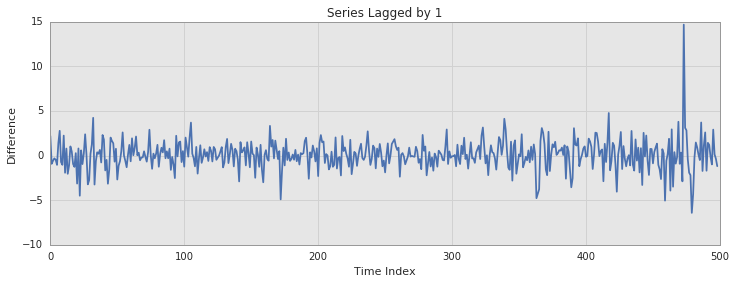

In [9]:
plot_lagged_series(tech.ix[-500:, 'FB'])

Now that we have detrended Facebook's stock lets look at the autocorrelations for the first 15 lags.

In [10]:
def plot_correlograms(series, limit=20):
    """
    Plots autocorrelations
    
    Args: series (ndarray)---the time series to view plots for
          limit (ndarry)-----the number of lags to see
    Returns: (None) plots inplace
    """
    
    fig = plt.figure(figsize=(15,8));
    fig.subplots_adjust(hspace=.5)
    ax1 = fig.add_subplot(211);
    fig = sm.graphics.tsa.plot_acf(series, lags=limit, ax=ax1);
    plt.title('Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    ax2 = fig.add_subplot(212);
    fig = sm.graphics.tsa.plot_pacf(series, lags=limit, ax=ax2);
    plt.title('Partial Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

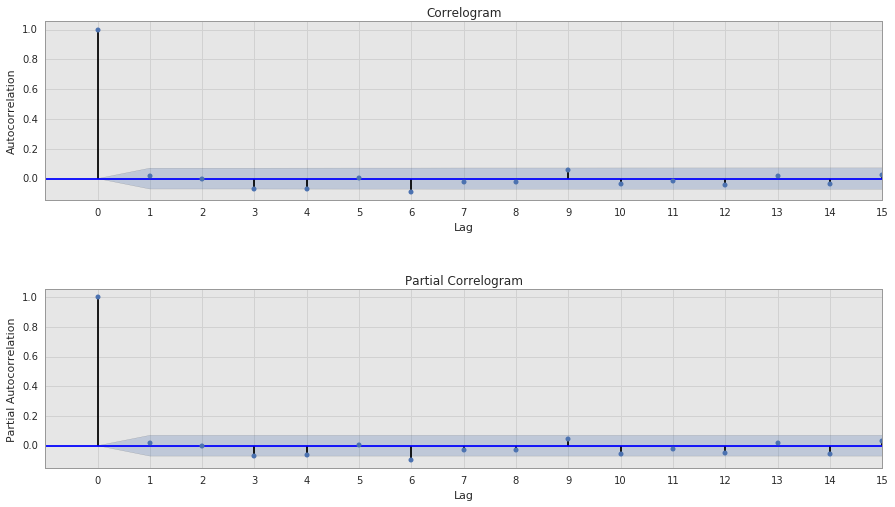

In [11]:
plot_correlograms(get_lagged_series(tech['FB']), limit=15)

Although we see slightly significant ACF and PACF values at lags 3 and 6, these are likely due to random chance, because we are conducting multiple tests. Overall we see what appears to be white noise.

#### Lets try the same with Apple.

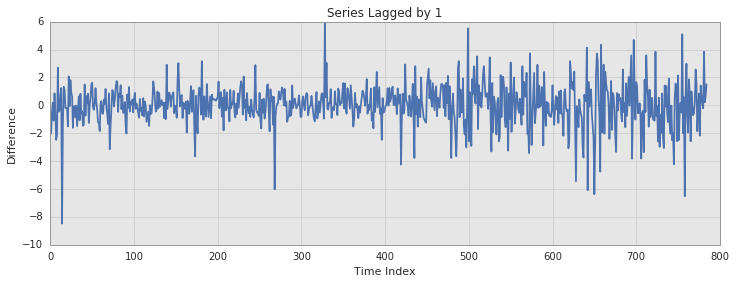

In [12]:
plot_lagged_series(tech['AAPL'])

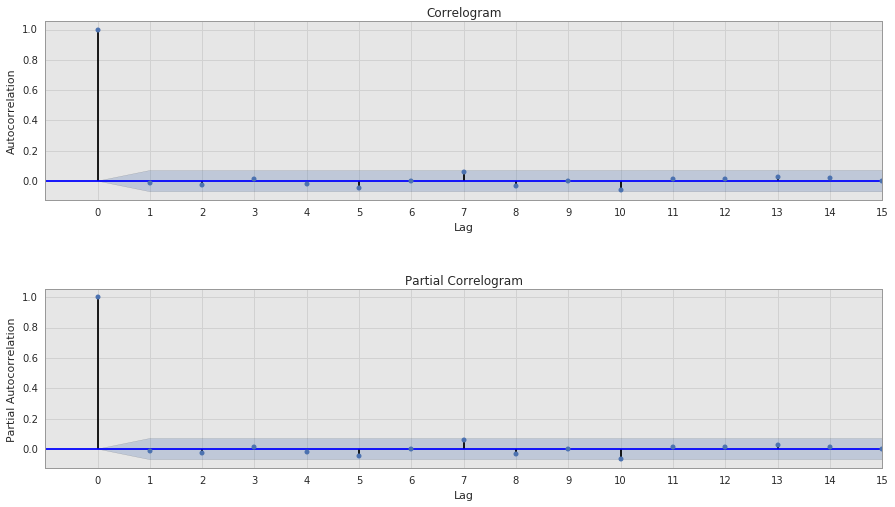

In [13]:
plot_correlograms(get_lagged_series(tech['AAPL']), limit=15)

Again we see what appears to be white noise. 

***
All the plotting functions above have been copied into _viz.py_ for use in other notebooks.